In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

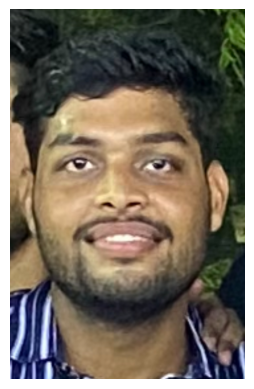

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = '/kaggle/input/testingk/IMG_9972.jpg'

img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()


In [6]:
#If my model do not perform well on the given dataset i will improve the quality using 
#pre trained models


import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the image
def load_image(image_path):
    img = Image.open(image_path)
    img = img.convert('RGB')
    img = np.array(img)
    img = tf.image.resize(img, [256, 256])  # Resize to the model's input size
    img = img / 255.0  # Normalize the image to [0, 1]
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    return img

image_path = '/kaggle/input/gender-classification-dataset/Training/female/131437.jpg.jpg'
low_res_image = load_image(image_path)



# Load the ESRGAN model from TensorFlow Hub
model = tf.keras.models.load_model('https://tfhub.dev/captain-pool/esrgan-tf2/1')

# Perform Super-Resolution
super_res_image = model(low_res_image)



2024-08-10 08:37:52.509763: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 08:37:52.509882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 08:37:52.747004: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, models, optimizers

2024-08-25 15:45:43.169595: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 15:45:43.169714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 15:45:43.442694: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#Load Pre-Trained Model
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense

# Model Callbacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [4]:
# Define ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2  # Assuming you'll use a part of the dataset for validation
)


#Use generators
df =  '/kaggle/input/gender-classification-dataset/Training'
train_generator = datagen.flow_from_directory(
    df, 
    target_size = (128, 128),
    batch_size  = 32, 
    class_mode  = 'binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    df, 
    target_size = (128, 128),
    batch_size  = 32,
    class_mode  = 'binary',
    subset='validation'
)

Found 37608 images belonging to 2 classes.
Found 9401 images belonging to 2 classes.


In [5]:
# Initializing the backbone layer
resnet = ResNet152V2(input_shape = (128, 128, 3), include_top = False, weights="imagenet")

# Freeze the backbone weights
resnet.trainable = False

# Creating a gender model
gender_net = Sequential([
    InputLayer((128, 128, 3), name="ImageInput"),
    resnet,
    Dropout(0.2, name = "SlightDroput"),
    GlobalAveragePooling2D(name="GlobalAvgPooling"),
    Dense(1, activation="sigmoid", name="gender")
], name="GenderNet")

gender_net.compile(
    loss = "binary_crossentropy",
    optimizer = 'adam',
    metrics = ['accuracy'],
    weighted_metrics=[]
)

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
# Training the Gender Model
gender_history = gender_net.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 6,
    batch_size = 32,
    callbacks = [
        EarlyStopping(
            patience = 5,
            monitor = "val_accuracy",
            restore_best_weights = True
        ),

        ModelCheckpoint(
            "Gender-ResNet152.keras",
            save_best_only=True
        )
    ]
)

Epoch 1/6


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   1/1176 ━━━━━━━━━━━━━━━━━━━━ 12:19:06 38s/step - accuracy: 0.5000 - loss: 0.8105

I0000 00:00:1724600889.900925     128 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1176/1176 ━━━━━━━━━━━━━━━━━━━━ 696s 561ms/step - accuracy: 0.8547 - loss: 0.3416 - val_accuracy: 0.8979 - val_loss: 0.2540
Epoch 2/6
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 304s 258ms/step - accuracy: 0.8987 - loss: 0.2644 - val_accuracy: 0.9076 - val_loss: 0.2415
Epoch 3/6
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 302s 255ms/step - accuracy: 0.9005 - loss: 0.2554 - val_accuracy: 0.9072 - val_loss: 0.2422
Epoch 4/6
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 303s 256ms/step - accuracy: 0.9019 - loss: 0.2472 - val_accuracy: 0.9141 - val_loss: 0.2217
Epoch 5/6
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 298s 252ms/step - accuracy: 0.9028 - loss: 0.2485 - val_accuracy: 0.9134 - val_loss: 0.2270
Epoch 6/6
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 302s 256ms/step - accuracy: 0.9031 - loss: 0.2481 - val_accuracy: 0.9131 - val_loss: 0.2282


In [7]:
# Evaluate the model
loss, accuracy = gender_net.evaluate(validation_generator, steps=10)
print(f'Validation Accuracy: {accuracy:.2f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.9477 - loss: 0.1646
Validation Accuracy: 0.93


In [9]:
# Save the trained model
gender_net.save('Gender_Prediction_model.h5')

In [8]:
train_generator.class_indices

{'female': 0, 'male': 1}

In [10]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess an image
img_path = '/kaggle/input/testingk/IMG_9972.jpg'
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

In [11]:
# Assuming you have your model and an input image loaded

# Get the predicted probabilities from the model
predicted_probabilities = gender_net.predict(img_array)

# Apply custom logic based on the threshold
threshold = 0.5  # You can adjust this threshold as needed
predicted_class = 1 if predicted_probabilities[0] > threshold else 0

# Define the class labels (assuming 0 is female and 1 is male)
class_labels = ['Female', 'Male']

# Get the final prediction
prediction = class_labels[predicted_class]

# Print the results
print(f"Predicted probabilities: {predicted_probabilities}")
print(f"Predicted class: {predicted_class}")
print(f"Prediction: {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Predicted probabilities: [[0.96421725]]
Predicted class: 1
Prediction: Male


In [12]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = (gender_net.predict(validation_generator) > 0.5).astype('int32')
y_true = validation_generator.classes

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


294/294 ━━━━━━━━━━━━━━━━━━━━ 77s 228ms/step
[[2284 2364]
 [2326 2427]]
              precision    recall  f1-score   support

           0       0.50      0.49      0.49      4648
           1       0.51      0.51      0.51      4753

    accuracy                           0.50      9401
   macro avg       0.50      0.50      0.50      9401
weighted avg       0.50      0.50      0.50      9401



Age-Detection Model

Intregating Age-Gender Detection Model


In [23]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import InputLayer, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf


In [24]:
# Define constants
IMAGE_SIZE = 224 
BATCH_SIZE = 32

# Function to extract age from filename
def extract_age(filename):
    return int(filename.split('_')[0])

# Load dataset and extract ages
dataset_dir = '/kaggle/input/agedetection/dataset/dataset'
filenames = [f for f in os.listdir(dataset_dir) if f.endswith('.jpg')]
ages = [extract_age(filename) for filename in filenames]

# Create a DataFrame with filenames and ages
df1 = pd.DataFrame({'filename': filenames, 'age': ages})

# Define the data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,     # Example augmentations
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create train and validation generators
train_gen = datagen.flow_from_dataframe(
    dataframe=df1,
    directory=dataset_dir,
    x_col='filename',
    y_col='age',
    subset='training',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw'
)

val_gen = datagen.flow_from_dataframe(
    dataframe=df1,
    directory=dataset_dir,
    x_col='filename',
    y_col='age',
    subset='validation',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw'
)


Found 18963 validated image filenames.
Found 4740 validated image filenames.


In [26]:
df1.dropna()

,filename,age
0,26_0_2_20170104023102422.jpg.chip.jpg,26
1,22_1_1_20170112233644761.jpg.chip.jpg,22
2,21_1_3_20170105003215901.jpg.chip.jpg,21
3,28_0_0_20170117180555824.jpg.chip.jpg,28
4,17_1_4_20170103222931966.jpg.chip.jpg,17
...,...,...
23698,41_0_0_20170109012220690.jpg.chip.jpg,41
23699,42_0_0_20170117185738076.jpg.chip.jpg,42
23700,2_0_2_20161219221701671.jpg.chip.jpg,2
23701,65_1_0_20170110182002744.jpg.chip.jpg,65


In [27]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load the pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model layers

# Add custom layers on top
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),  # Increased dropout to help prevent overfitting
    Dense(1)  # Single output for regression
])

model.compile(optimizer='adam', loss='mae')
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks for early stopping and saving the best model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = True
# Recompile with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='mae')

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1724605987.811770     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


524/593 ━━━━━━━━━━━━━━━━━━━━ 43s 635ms/step - loss: 14.9569

W0000 00:00:1724606372.848031     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


593/593 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - loss: 14.5656

W0000 00:00:1724606415.690166     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


593/593 ━━━━━━━━━━━━━━━━━━━━ 613s 888ms/step - loss: 14.5604 - val_loss: 9.4323
Epoch 2/10


W0000 00:00:1724606513.535810     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


593/593 ━━━━━━━━━━━━━━━━━━━━ 306s 511ms/step - loss: 8.8879 - val_loss: 7.8485
Epoch 3/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 299s 499ms/step - loss: 7.9398 - val_loss: 7.5713
Epoch 4/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 301s 503ms/step - loss: 7.4606 - val_loss: 7.2149
Epoch 5/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 301s 502ms/step - loss: 7.1775 - val_loss: 7.2413
Epoch 6/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 305s 510ms/step - loss: 7.0373 - val_loss: 6.8176
Epoch 7/10
593/593 ━━━━━━━━━━━━━━━━━━━━ 307s 512ms/step - loss: 6.7153 - val_loss: 6.6568
Epoch 8/10
163/593 ━━━━━━━━━━━━━━━━━━━━ 2:56 411ms/step - loss: 6.5951

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_image(img_path, target_size):
    # Load the image file
    img = image.load_img(img_path, target_size=target_size)
    
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    
    # Expand dimensions to match the input shape of the model
    img_array = np.expand_dims(img_array, axis=0)
    
    # Preprocess the image for the model
    img_array = preprocess_input(img_array)
    
    return img_array

In [ ]:
# Path to the image you want to predict
img_path = '/kaggle/input/age-prediction/20-50/20-50/test/49/33569.jpg'

# Preprocess the image
preprocessed_image = preprocess_image(img_path, target_size=(224, 224))

# Make a prediction
predicted_age = model.predict(preprocessed_image)/10

# Print the predicted age
print(f"Predicted Age: {predicted_age[0][0]:.2f}")


Gender & Age Model are Intregated

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the models
gender_model = load_model('/kaggle/input/genderprediction/tensorflow2/default/1/Gender_Prediction_model.h5')
age_model = load_model('/kaggle/input/ageprediction/tensorflow2/default/1/age_prediction_model(new).h5')

# Function to preprocess the image
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize if needed
    return img_array

# Predict function
def predict_age_and_gender(img_path):
    # Preprocess the image for gender model (128x128)
    img_array_gender = preprocess_image(img_path, target_size=(128, 128))
    
    # Preprocess the image for age model (224x224)
    img_array_age = preprocess_image(img_path, target_size=(224, 224))
    
    # Predict gender
    gender_prediction = gender_model.predict(img_array_gender)
    gender = 'Male' if gender_prediction[0] < 0.5 else 'Female'

    # Predict age
    age_prediction = age_model.predict(img_array_age)
    predicted_age = np.argmax(age_prediction)  # Adjust this if your model outputs a single age value

    return gender, predicted_age

# Example usage
img_path = '/kaggle/input/age-prediction/20-50/20-50/train/24/141095.jpg'
gender, age = predict_age_and_gender(img_path)
print(f"Predicted Gender: {gender}")
print(f"Predicted Age: {age}")
